In [2]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
image_dir = "/kaggle/input/face-mask-detection/images"          # e.g., images/
annotation_dir = "/kaggle/input/face-mask-detection/annotations"  # e.g., annotations/
IMG_SIZE = 300
categories = ["with_mask", "without_mask", "mask_weared_incorrect"]

In [4]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []
    for obj in root.findall("object"):
        name = obj.find("name").text
        bbox = obj.find("bndbox")
        xmin = int(float(bbox.find("xmin").text))
        ymin = int(float(bbox.find("ymin").text))
        xmax = int(float(bbox.find("xmax").text))
        ymax = int(float(bbox.find("ymax").text))
        objects.append((name, xmin, ymin, xmax, ymax))
    return objects

In [5]:
data = []
labels = []

for xml_file in os.listdir(annotation_dir):
    if not xml_file.endswith(".xml"):
        continue

    image_filename = xml_file.replace(".xml", ".png")  # or .jpg based on your dataset
    image_path = os.path.join(image_dir, image_filename)
    xml_path = os.path.join(annotation_dir, xml_file)

    if not os.path.exists(image_path):
        continue

    image = cv2.imread(image_path)
    if image is None:
        continue

    objects = parse_annotation(xml_path)
    for label, xmin, ymin, xmax, ymax in objects:
        if label not in categories:
            continue
        cropped_face = image[ymin:ymax, xmin:xmax]
        try:
            cropped_face = cv2.resize(cropped_face, (IMG_SIZE, IMG_SIZE))
            cropped_face = preprocess_input(cropped_face)
            data.append(cropped_face)
            labels.append(categories.index(label))
        except:
            continue

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


In [6]:
X = np.array(data, dtype="float32")
y = to_categorical(np.array(labels), num_classes=3)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [8]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_aug = ImageDataGenerator()


In [9]:
base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1751789829.788953      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751789829.789557      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 300, 300, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 300, 300, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 300, 300, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 300, 300, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 301, 301, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 150, 150, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 150, 150, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 150, 150, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 150, 150, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 150, 150, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 150, 150, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 10,980,658 (41.89 MB)

 Trainable params: 197,123 (770.01 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [10]:
history = model.fit(
    train_aug.flow(X_train, y_train, batch_size=32),
    validation_data=val_aug.flow(X_val, y_val),
    steps_per_epoch=len(X_train) // 32,
    validation_steps=len(X_val) // 32,
    epochs=20
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1751789860.153565      98 service.cc:148] XLA service 0x7bf06c21c220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751789860.154544      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751789860.154578      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751789863.142878      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/101 ━━━━━━━━━━━━━━━━━━━━ 1:17:20 46s/step - accuracy: 0.3125 - loss: 1.1381

I0000 00:00:1751789881.102580      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


101/101 ━━━━━━━━━━━━━━━━━━━━ 134s 878ms/step - accuracy: 0.6620 - loss: 0.7779 - val_accuracy: 0.8037 - val_loss: 0.4638
Epoch 2/20
  1/101 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.8125 - loss: 0.5788

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8125 - loss: 0.5788 - val_accuracy: 0.8000 - val_loss: 0.4665
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 61s 604ms/step - accuracy: 0.7898 - loss: 0.5150 - val_accuracy: 0.8587 - val_loss: 0.4043
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7188 - loss: 0.5725 - val_accuracy: 0.8637 - val_loss: 0.3965
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 62s 609ms/step - accuracy: 0.8244 - loss: 0.4582 - val_accuracy: 0.8763 - val_loss: 0.3644
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8438 - loss: 0.5398 - val_accuracy: 0.8775 - val_loss: 0.3648
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 62s 609ms/step - accuracy: 0.8547 - loss: 0.4103 - val_accuracy: 0.8775 - val_loss: 0.3521
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8438 - loss: 0.5247 - val_accuracy: 0.8775 - val_loss: 0.3504
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 61s 607ms/step - accuracy: 0.8443 - loss: 0.4181 - val_accurac

26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 645ms/step

Classification Report:

                       precision    recall  f1-score   support

            with_mask       0.94      0.92      0.93       647
         without_mask       0.69      0.85      0.76       143
mask_weared_incorrect       1.00      0.04      0.08        25

             accuracy                           0.88       815
            macro avg       0.87      0.60      0.59       815
         weighted avg       0.90      0.88      0.87       815



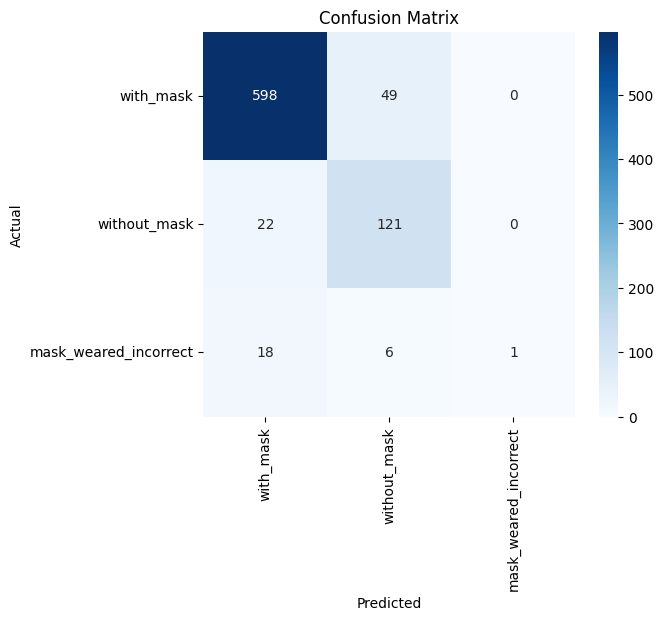

In [11]:
val_preds = model.predict(X_val, batch_size=32)
val_preds_labels = np.argmax(val_preds, axis=1)
true_labels = np.argmax(y_val, axis=1)

print("\nClassification Report:\n")
print(classification_report(true_labels, val_preds_labels, target_names=categories))

# Confusion Matrix
cm = confusion_matrix(true_labels, val_preds_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

Prediction for test image:
Label: with_mask
Confidence: 0.80


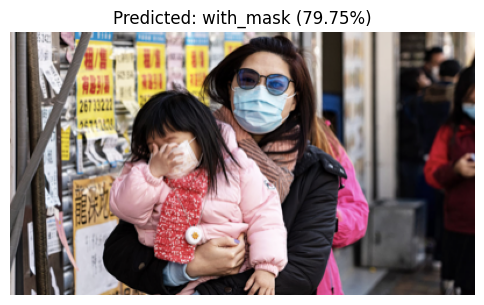

In [12]:

from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to test image
test_image_path = "/kaggle/input/face-mask-detection/images/maksssksksss100.png"  # CHANGE THIS

# Load and preprocess
img = load_img(test_image_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = img_to_array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)[0]
confidence = np.max(pred)
pred_label = categories[pred_class]

# Show result
print(f"\nPrediction for test image:")
print(f"Label: {pred_label}")
print(f"Confidence: {confidence:.2f}")

# Visualize
original = cv2.imread(test_image_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(original)
plt.title(f"Predicted: {pred_label} ({confidence*100:.2f}%)")
plt.axis("off")
plt.show()